In [1]:
import numpy as np
import matplotlib.pyplot as plt

# TODO: make 1D truss linear solver with fixed area and constant material properties


In [283]:
class TrussElement:
    def __init__(self, node_indeces, E, A, length, q,shape_function="linear"):
        self.nodes = node_indeces
        self.E = E
        self.A = A
        self.length = length
        self.q = q
        self.shape_function = shape_function

    def stiffness_matrix(self):
        if self.shape_function == "linear":
            k = self.E * self.A / self.length
            return k*np.array([[1, -1], [-1, 1]])
        elif self.shape_function == "quadratic":
            k = self.E * self.A / (self.length*3)
            return k*np.array([[7, -8, 1], [-8, 16, -8], [1, -8, 7]])

    def load_vector(self):
        # Calculate the load vector for the element
        if self.shape_function == "linear":
            return np.array([self.q*self.length / 2, self.q*self.length / 2])
        elif self.shape_function == "quadratic":
            return np.array([self.q*self.length / 6, 4*self.q*self.length / 6, self.q*self.length / 6])

    def __repr__(self):
        return f"TrussElement(nodes={self.nodes}"


In [284]:
# N, mm, MPa

class Truss1D:
    def __init__(self, num_elem, E, A, L, q = 0, F_applied_at_end = 0, shape_function="linear"):
        self.num_elem = num_elem
        self.E = E
        self.A = A
        self.L = L
        self.q = q # distributed load, N/mm
        self.F_applied_at_end = F_applied_at_end # N
        self.shape_function = shape_function

        self.elements = np.zeros(num_elem, dtype=TrussElement)
        self.num_nodes = self.num_elem + 1 if shape_function == "linear" else 2*self.num_elem + 1

    def create_elements(self):
        # create TrussElemets for a specified length of truss with num_elements
        element_length = self.L / self.num_elem
        for i, element_i in enumerate(range(self.num_elem)):

            if self.shape_function == "linear":
                node_indeces = [element_i, element_i + 1]
            elif self.shape_function == "quadratic":
                node_indeces = [2*element_i-1, 2*element_i, 2*element_i+1]

            self.elements[i] = TrussElement(node_indeces, self.E,  self.A, element_length,q=self.q, shape_function=self.shape_function)

    def __repr__(self):
        return self.elements


In [285]:
class TrussSolver:
    def __init__(self, truss : Truss1D):
        self.truss = truss

        self.K_global = np.zeros((self.truss.num_nodes, self.truss.num_nodes))
        self.F_global = np.zeros(self.truss.num_nodes)
        self.displacements = None

    def solve(self):
        self.assemble_global_matrices()
        self.solve_displacements()
        self.compute_stresses()
        return self.displacements, self.stresses

    def assemble_global_matrices(self):
        # Assemble the global stiffness and load vector
        node_per_element = len(self.truss.elements[0].nodes)

        for i, element in enumerate(self.truss.elements):
            k_element = element.stiffness_matrix()
            for j in range(node_per_element):
                for k in range(node_per_element):
                    self.K_global[element.nodes[j], element.nodes[k]] += k_element[j, k]

        for i, element in enumerate(self.truss.elements):
            for j in range(node_per_element):
                f_element = element.load_vector()
                self.F_global[element.nodes[j]] += f_element[j]
        self.F_global[-1] += self.truss.F_applied_at_end

        return self.K_global, self.F_global

    def solve_displacements(self):
        # Solve for displacements
        Kuu = self.K_global[1:,1:]
        Fu = self.F_global[1:]
        self.displacements = np.linalg.solve(Kuu, Fu)
        self.displacements = np.insert(self.displacements, 0, 0)
        return self.displacements

    def compute_stresses(self):
        # Calculate stresses in each element
        self.stresses = np.zeros(self.truss.num_elem)
        for i, element in enumerate(self.truss.elements):
            del_x = element.length if self.truss.shape_function == "linear" else 0.5*element.length
            del_u = (self.displacements[element.nodes[0]] - self.displacements[element.nodes[1]])
            self.stresses[i] = self.truss.E * del_u / del_x
        return self.stresses




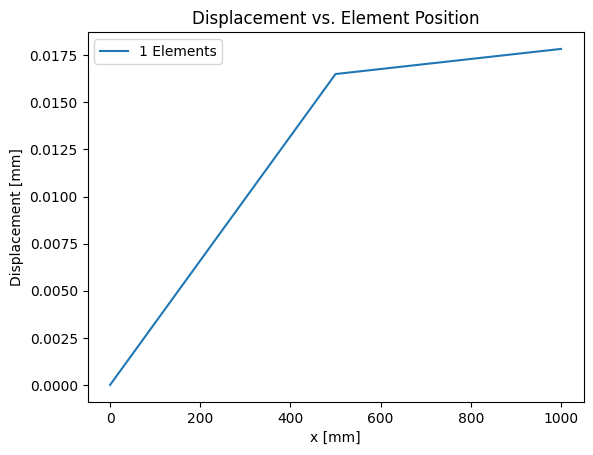

In [312]:
E=50*10**3
A=75
L=1000

num_elem = 1
my_truss = Truss1D(num_elem, E, A, L, q = 1, F_applied_at_end=10, shape_function="quadratic")
my_truss.create_elements()


solver = TrussSolver(my_truss)
solver.solve()

# print(solver.K_global, solver.F_global, solver.displacements, solver.stresses)

plotter = Plotter(solver)
plotter.plot_displacements()
# plotter.plot_stresses()

In [272]:

class Plotter:
    def __init__(self, truss_solver):
        self.truss_solver = truss_solver

    def plot_displacements(self):
        x = np.linspace(0, self.truss_solver.truss.L, self.truss_solver.truss.num_nodes)
        plt.plot(x, self.truss_solver.displacements, label=f'{self.truss_solver.truss.num_elem} Elements')
        plt.title('Displacement vs. Element Position')
        plt.xlabel('x [mm]')
        plt.ylabel('Displacement [mm]')
        plt.legend()
        plt.show()

    def plot_stresses(self):
        x = np.linspace(0, self.truss_solver.truss.L, self.truss_solver.truss.num_nodes)
        # To create a stepped plot
        x_rep = np.repeat(x, 2)
        sigma_rep = np.repeat(self.truss_solver.stresses, 2)
        plt.plot(x_rep[1:-1], sigma_rep, label=f'{self.truss_solver.truss.num_elem} Elements')
        plt.title('Stress vs. Element Position')
        plt.xlabel('x [mm]')
        plt.ylabel('Stress [MPa]')
        plt.legend()
        plt.show()


In [263]:
K, F, u, sigma = solver.K_global, solver.F_global, solver.solve_displacements(), solver.compute_stresses()

u, sigma

(array([ 0.        , -0.00016667,  0.00116667]), array([0.11666667]))